In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

before img.size: (3210, 3216)
after img.size: 128
before shape: torch.Size([3, 128, 128])
after shape: torch.Size([1, 3, 128, 128])
before img.size: (2487, 2487)
after img.size: 128
before shape: torch.Size([3, 128, 128])
after shape: torch.Size([1, 3, 128, 128])


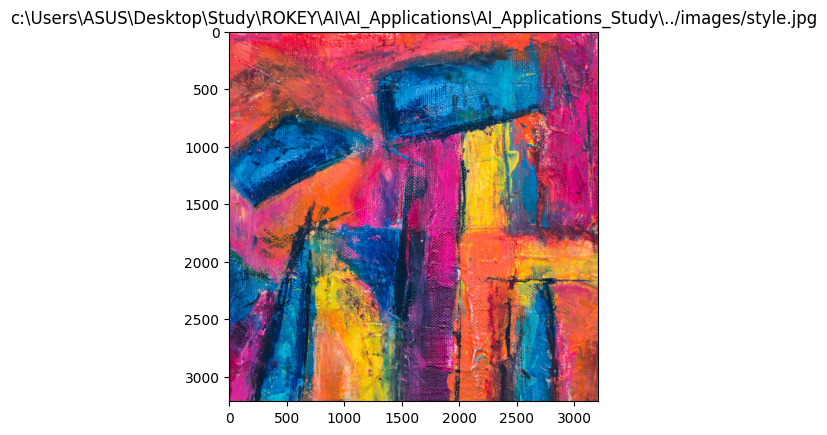

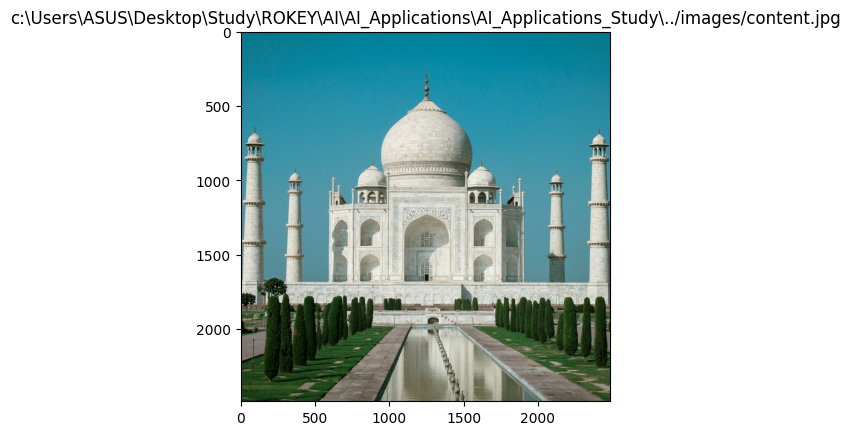

In [14]:
def image_to_tensor(image_filepath, image_dimension=128):
    img = Image.open(image_filepath).convert('RGB')

    plt.figure()
    plt.title(image_filepath)
    plt.imshow(img)

    print("before img.size:", img.size)
    if max(img.size) <= image_dimension:
        img_size = max(img.size)
    else:
        img_size = image_dimension
    print("after img.size:", img_size)

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor()
    ])

    print('before shape:', torch_transformation(img).shape)
    img = torch_transformation(img).unsqueeze(0)
    print('after shape:', img.shape)
    print('='*50)

    return img.to(device, torch.float)

style_image = image_to_tensor(os.path.join(os.getcwd(), '../images/style.jpg'))
content_image = image_to_tensor(os.path.join(os.getcwd(), '../images/content.jpg'))

In [15]:
def gram_matrix(ip):
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch*num_channels, width*height)
    gram_mat = torch.mm(feats, feats.t())
    return gram_mat.div(num_batch*num_channels*width*height)

In [16]:
weights = torchvision.models.VGG19_Weights.DEFAULT
vgg19_model = torchvision.models.vgg19(weights=weights).to(device)
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
vgg19_model = vgg19_model.features
print(vgg19_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [18]:
for param in vgg19_model.parameters():
    param.requires_grad_(False)

In [19]:
vgg19_model[3]

ReLU(inplace=True)

In [22]:
conv_indices = []

print('len(vgg19_model):', len(vgg19_model))
for i in range(len(vgg19_model)):
    if vgg19_model[i]._get_name() == 'Maxpool2d':
        vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size,
                                      stride=vgg19_model[i].stride,
                                      padding=vgg19_model[i].padding)
    if vgg19_model[i]._get_name() == 'Conv2d':
        conv_indices.append(i)

conv_indices = dict(enumerate(conv_indices, start=1))
print(vgg19_model)
display('conv_indices:',conv_indices)

len(vgg19_model): 37
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace

'conv_indices:'

{1: 0,
 2: 2,
 3: 5,
 4: 7,
 5: 10,
 6: 12,
 7: 14,
 8: 16,
 9: 19,
 10: 21,
 11: 23,
 12: 25,
 13: 28,
 14: 30,
 15: 32,
 16: 34}

In [23]:
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}

In [25]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(10, 20),
            nn.Linear(20, 30),
            nn.Linear(30, 40),
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = CustomModel()
x = torch.randn(1, 10)
print('torch.randn(1, 10) :')
print(x)
output = model(x)
print('output :')
print(output)
print(output.shape)

torch.randn(1, 10) :
tensor([[ 0.2437,  0.3281,  0.6241,  1.0119,  0.1475,  0.6183,  1.3374,  0.4147,
         -1.6371,  2.0008]])
output :
tensor([[ 0.6166, -0.0436, -0.2225, -0.1893, -0.0412,  0.1957,  0.1703, -0.1993,
          0.3458, -0.0973, -0.0948, -0.0926, -0.0073, -0.1571,  0.1575,  0.3820,
         -0.0652,  0.4252, -0.1331, -0.0894, -0.2028, -0.0580,  0.0845, -0.3281,
          0.2980, -0.0754,  0.3248,  0.1819,  0.3056, -0.2568, -0.0872,  0.0615,
          0.2395, -0.6520,  0.1262,  0.2436, -0.2479, -0.2889, -0.2646,  0.2320]],
       grad_fn=<AddmmBackward0>)
torch.Size([1, 40])


In [26]:
model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 30),
    nn.ReLU(),
    nn.Linear(30, 40),
)

x = torch.randn(1, 10)
output = model(x)
print(output.shape)

torch.Size([1, 40])


In [27]:
vgg_layers = nn.ModuleList(vgg19_model)
vgg_layers

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [28]:
display(conv_indices)

{1: 0,
 2: 2,
 3: 5,
 4: 7,
 5: 10,
 6: 12,
 7: 14,
 8: 16,
 9: 19,
 10: 21,
 11: 23,
 12: 25,
 13: 28,
 14: 30,
 15: 32,
 16: 34}

In [30]:
print('max(layers.keys()) :', max(layers.keys()))
last_layer_idx = conv_indices[max(layers.keys())]
vgg_layers_trimmed = vgg_layers[:last_layer_idx+1]
print('conv_indices[5] :',last_layer_idx)
vgg_layers_trimmed

max(layers.keys()) : 5
conv_indices[5] : 10


ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [39]:
neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([3, 128, 128])
(128, 128, 3)
0.0
1.0


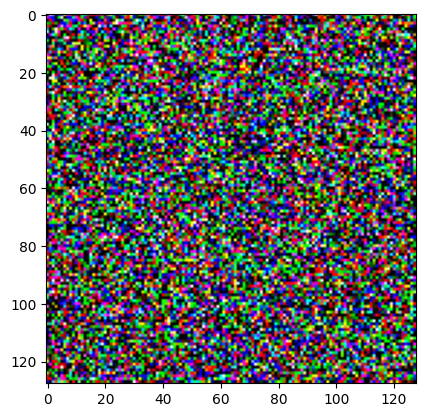

In [34]:
print(content_image.data.size())
ip_image = torch.randn(content_image.data.size(), device=device)
print(ip_image.shape)
print(ip_image.squeeze(0).shape)
print(ip_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0).clip(0, 1).shape)
print(ip_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0).clip(0, 1).min())
print(ip_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0).clip(0, 1).max())

plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0).clip(0, 1))
plt.show()

In [35]:
print(layers.keys())
print(layers)

dict_keys([1, 2, 3, 4, 5])
{1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}


In [36]:
ip_image.requires_grad_()

tensor([[[[-0.0059,  1.3139,  0.4667,  ...,  1.4033, -1.1178,  0.1720],
          [ 1.7713,  0.1608, -0.0789,  ...,  0.1859,  0.2364, -0.6660],
          [-0.0644,  1.2707,  0.1213,  ..., -0.4794,  0.1409,  0.1386],
          ...,
          [ 1.9068, -0.3800, -0.8759,  ..., -0.1552, -1.0022, -0.8708],
          [ 1.1496,  1.3310, -0.2785,  ..., -1.1428, -0.9700, -0.2886],
          [-0.8309, -0.3064,  0.4264,  ...,  0.4754,  0.4052, -1.2229]],

         [[-0.0449,  0.7969,  0.6423,  ..., -1.8432, -1.1614,  1.6269],
          [-1.1120, -0.5327, -1.1771,  ...,  0.9490, -0.2848,  1.1954],
          [-0.3831, -0.3011,  0.0326,  ...,  1.2180, -0.7265,  0.4337],
          ...,
          [-1.5845,  0.1357,  0.4478,  ...,  1.3885,  1.3471,  0.1959],
          [-0.1313, -0.3179, -1.5069,  ...,  1.1601,  0.5131,  0.1732],
          [-0.4966, -1.0121,  0.6750,  ...,  0.1487, -0.2720, -0.0618]],

         [[-0.0233,  1.7233,  0.9911,  ...,  0.4240, -0.3474, -0.2256],
          [ 1.4342,  3.4057,  

In [37]:
def gram_matrix(input_tensor):  
    batch, channels, height, width = input_tensor.size()  
    features = input_tensor.view(channels, height * width)  
    gram = torch.mm(features, features.t())  
    return gram

epoch number 0
style_loss = 6793269248.000, content_loss = 24.106


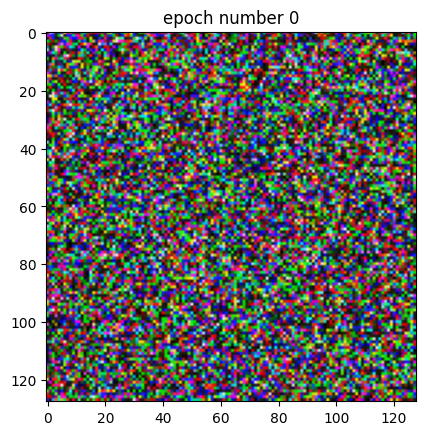

epoch number 500
style_loss = 438475.000, content_loss = 10.610


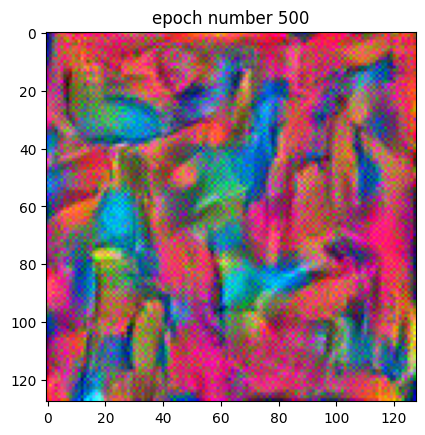

epoch number 1000
style_loss = 115815.906, content_loss = 10.617


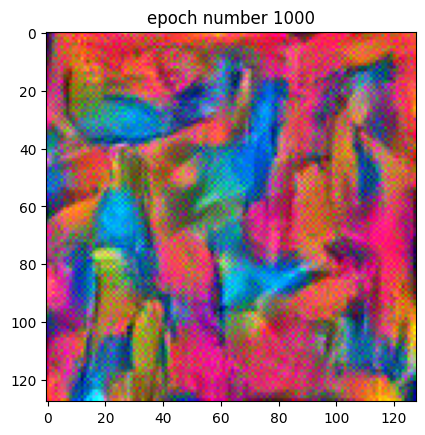

In [40]:
num_epochs = 1000
wt_style = 1
wt_content = 1
style_losses = []
content_losses = []
optimizer = optim.Adam([ip_image.requires_grad_()], lr=0.1)

for curr_epoch in range(num_epochs+1):

    ip_image.data.clamp_(0, 1)
    optimizer.zero_grad()
    epoch_style_loss = 0
    epoch_content_loss = 0

    for k in layers.keys():
        if 'c' in layers[k]:
            target = neural_style_transfer_model[:conv_indices[k]+1](content_image).detach()
            ip = neural_style_transfer_model[:conv_indices[k]+1](ip_image)
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
        if 's' in layers[k]:
            target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](style_image)).detach()
            ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](ip_image))
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward()
    optimizer.step()
    
    if curr_epoch % 500 == 0:
        print(f"epoch number {curr_epoch}")
        print(f"style_loss = {epoch_style_loss:.3f}, content_loss = {epoch_content_loss:.3f}")
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
        plt.show()
        
    style_losses.append(epoch_style_loss.item())
    content_losses.append(epoch_content_loss.item())

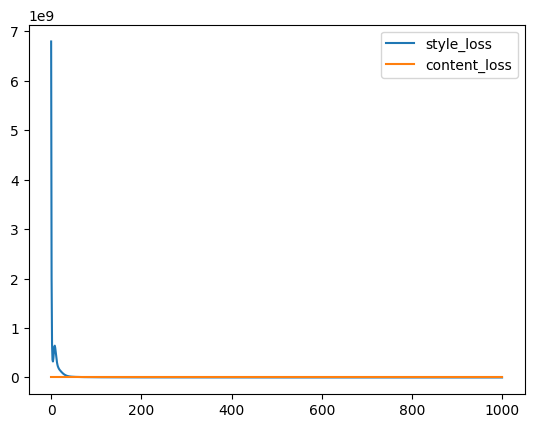

In [41]:
plt.plot(range(len(style_losses)), torch.tensor(style_losses), label='style_loss')
plt.plot(range(len(content_losses)), torch.tensor(content_losses), label='content_loss')
plt.legend()
plt.show()